In [1]:
import torch
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

from torchsummary import summary
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(256)])

train_ok_path = '~/Bureau/zentout/dataset/archive/casting_data/casting_data/train_one_class'
trainset = torchvision.datasets.ImageFolder(train_ok_path, transform = transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle = True, num_workers=5)

train_def_path = '~/Bureau/zentout/dataset/archive/casting_data/casting_data/train_anomalous'
trainset_def = torchvision.datasets.ImageFolder(train_def_path, transform = transform)
trainloader_def = DataLoader(trainset_def, batch_size=1, shuffle = False)

test_path = '~/Bureau/zentout/dataset/archive/casting_data/casting_data/test'
testset = torchvision.datasets.ImageFolder(test_path, transform = transform)
testloader = DataLoader(testset, batch_size=1, shuffle = False)

classes = ['def','ok']

In [38]:
class Autoencoder(nn.Module):
    def __init__(self,enc_out_dim=512, latent_dim=32, input_height=256):
        super(Autoencoder, self).__init__()
        
        
        #encoder and decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        
        self.fc = nn.Linear(512, 32)
        
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        x = self.decoder(x)
        
        return x


In [48]:
def train(model, opt, trainloader, testloader, epochs):
    losses = []
    i = 0
    for epoch in range(epochs):
        print("starting training")
        step_loss = 0
        
        for images, labels in trainloader:
            out = model(images.to('cuda'))
            
            opt.zero_grad()
            
            loss = loss_function(out, images.to('cuda'))
            step_loss += loss.item()
            loss.backward()
            opt.step()
            
            losses.append(loss.item())
            
            if i%200 == 199:
                print(f'[Epoch : {epoch + 1}, step : {i}] loss : {step_loss/200}')
                step_loss = 0
            i+=1
        
        print(f'finished epoch {epoch +1}')
            
        if epoch%2 == 0:
            print('starting validation')
            val_losses = []
            def_losses = []
            ok_losses = []
            val_labels = []
            predictions = []
            model.eval()
            for val_image, label in testloader:
                val_out = model(val_image.to('cuda'))
                loss = loss_function(val_out,val_image.to('cuda'))
                val_losses.append(loss.item())
                val_labels.append(classes[label])
                
                if label.item() == 0:
                    def_losses.append(loss.item())
                else:
                    ok_losses.append(loss.item())
                
            threshold = max(ok_losses)
            for l in val_losses:
                if l > threshold:
                    predictions.append(classes[0])
                else:
                    predictions.append(classes[1])
            
            # Save losses density image
            save_validation_losses_density(epoch, val_losses, val_labels)
            #save_confusion_matrix(epoch, val_labels, predictions)
            
            print(f'def_valid_loss : {sum(def_losses)/len(def_losses)} ')
            print(f'ok_valid_loss : {sum(ok_losses)/len(ok_losses)} ')
            
    return losses

In [60]:
def save_validation_losses_density(epoch, val_losses, val_labels):
    if not os.path.exists('AE_density_images'):
            os.makedirs('AE_density_images')
    df = pd.DataFrame(val_losses, columns=['loss'])
    df['labels'] = val_labels
    #df_def = pd.DataFrame(losses_def, columns=['loss_def'])
    sns.displot(df,x="loss" ,hue="labels", kind="kde")
    plt.savefig(f"AE_density_images/Density-epoch-{epoch+1}.png")

In [61]:
ae = Autoencoder().to('cuda')
opt = torch.optim.Adam(ae.parameters(), lr=0.001)
loss_function = nn.MSELoss()
summary(ae, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 256, 256]          36,864
       BatchNorm2d-6         [-1, 64, 256, 256]             128
              ReLU-7         [-1, 64, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          36,864
       BatchNorm2d-9         [-1, 64, 256, 256]             128
             ReLU-10         [-1, 64, 256, 256]               0
     EncoderBlock-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
      BatchNorm2d-13         [-1, 64, 256, 256]             128
             ReLU-14         [-1, 64, 2

starting training
[Epoch : 1, step : 199] loss : 0.054216847056522965
finished epoch 1
starting validation
def_valid_loss : 0.032475591668032655 
ok_valid_loss : 0.028260183769441744 
starting training
[Epoch : 2, step : 399] loss : 0.46545554380863907
[Epoch : 2, step : 599] loss : 0.03681947481818497
finished epoch 2
starting training
[Epoch : 3, step : 799] loss : 0.01397304761223495
[Epoch : 3, step : 999] loss : 0.03398853474296629
finished epoch 3
starting validation
def_valid_loss : 0.031333241426688155 
ok_valid_loss : 0.03304668753727816 
starting training
[Epoch : 4, step : 1199] loss : 0.019420267110690476
[Epoch : 4, step : 1399] loss : 0.03159947725944221
finished epoch 4
starting training
[Epoch : 5, step : 1599] loss : 0.02450980502180755
[Epoch : 5, step : 1799] loss : 0.029880616161972285
finished epoch 5
starting validation
def_valid_loss : 0.028720435166266843 
ok_valid_loss : 0.029423817999319722 


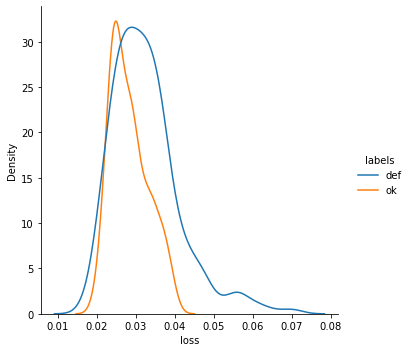

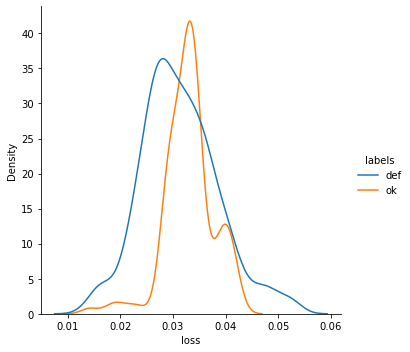

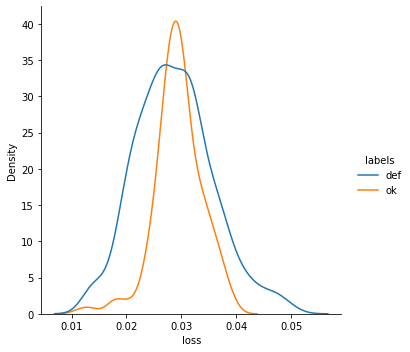

In [62]:
losses = train(ae, opt, trainloader,testloader, 5)
#torch.save(vae.state_dict(), 'vae_epochs_final.pt')

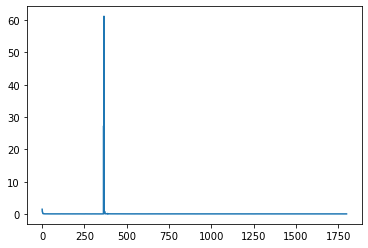

In [64]:
plt.plot(losses[0:-1])